# week 09 project
<hr style="border:2px solid black">

## 1. Introduction

**What is transfer learning?**
- one of the most powerful ideas of deep learning
- taking knowledge learned from one task, and leveraging it on a similar but new task

<hr style="border:2px solid black">

## 2. Pre-trained Model

### 2.1 Load packages

In [17]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# miscellaneous
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# deep learning stack
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image

In [18]:
# tensorflow and keras version
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

TensorFlow version: 2.12.0
Keras version: 2.12.0


### 2.2 Load model

[`mobilenet_v2`](https://keras.io/api/applications/mobilenet/)

In [19]:
from tensorflow.keras.applications.mobilenet_v2 import (
    MobileNetV2,
    preprocess_input,
    decode_predictions
)

**instantiate model**

In [20]:
pretrained_model = MobileNetV2(
    weights='imagenet'
)

**model summary**

In [21]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### 2.3 User-defined functions

In [22]:
def load_image(image_path):
    """
    loads an input image into PIL format of size 224 X 224
    """
    img = image.load_img(
        path=image_path,
        target_size=(224,224)
    )
    return img

In [23]:
def batch_image(loaded_image):
    """
    converts a loaded image to a batch
    """
    img_array = image.img_to_array(loaded_image)
    img_batch = np.array([img_array])
    
    return img_batch

In [24]:
def preprocess_image(batched_image):
    """
    preprocesses a batch image to make suitable for mobilenet_v2
    """
    processed_img = preprocess_input(batched_image)
    
    return processed_img

In [25]:
def show_preprocess_image(image_path):
    """
    shows loaded image given an image path, and
    preprocesses it to make suitable for mobilenet_v2
    """
    # load resized image
    loaded_img = load_image(image_path)
    
    # display image
    plt.figure(figsize=(3,3), dpi=100)
    plt.imshow(loaded_img)
    
    # create batched image
    batch_img = batch_image(loaded_img)
    
    # preprocess image
    processed_img = preprocess_image(batch_img)
    
    return processed_img

In [26]:
def image_class_prediction(model, preprocessed_image):
    """
    spits out the top-5 predictions of a given model with a proprocessed image
    """
    model_prediction = model.predict(preprocessed_image,verbose=0)
    decoded_prediction = decode_predictions(model_prediction,top=5)[0]
    data = {
        'image_class': [_[1] for _ in decoded_prediction],
        'probability': [_[2] for _ in decoded_prediction]
    }
    df = pd.DataFrame(data=data)
    return df

### 2.4 Model evaluation

**image classes**

In [27]:
CLASSES = os.listdir('raw')
CLASSES

['0', '1']

**negative**

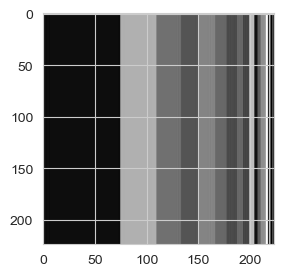

In [28]:
# show and preprocess image

testi_image = show_preprocess_image(
    'raw/0/pic3.jpg'
)

In [29]:
# class prediction

image_class_prediction(
    pretrained_model,
    testi_image
)

,image_class,probability
0,sliding_door,0.212205
1,window_shade,0.084804
2,wardrobe,0.036775
3,radiator,0.032647
4,window_screen,0.023214


**positiv**

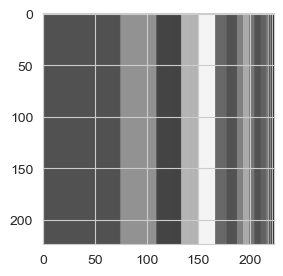

In [30]:
# show and preprocess image

pos_image = show_preprocess_image(
    'raw/1/pic1.jpg'
)

In [31]:
# class prediction

image_class_prediction(
    pretrained_model,
    pos_image
)

,image_class,probability
0,window_shade,0.120720
1,sliding_door,0.114113
2,shoji,0.043473
3,prison,0.040218
4,wardrobe,0.040185


<hr style="border:2px solid black">

## 3. Transfer Learning Example

[**getting training images into keras**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [32]:
# instantiate image data generator

data_gen = image.ImageDataGenerator(
    # preprocessing function for all images
    preprocessing_function=preprocess_input
)

In [33]:
# generate batches of x and y arrays from directory

train_data_gen = data_gen.flow_from_directory(
        directory='raw',
        class_mode="categorical",
        classes=CLASSES,
        batch_size=400,
        target_size=(224,224)
)

Found 32 images belonging to 2 classes.


In [34]:
# load in all images at once

xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((32, 224, 224, 3), (32, 2))

### 3.1 Model Building 

**3.1.1 Select convolutional base with frozen weights**

In [35]:
# define base model

BASE_MODEL = MobileNetV2(
    weights='imagenet', 
    alpha=1.0,          # controls number of overall weights
    include_top=False,  # removal of final dense layers
    pooling='avg',      # average pooling to last convolutional layer's ouput
    input_shape=(224,224,3) # ignored if input tensor is provided
)

In [36]:
# freeze base model
BASE_MODEL.trainable = False

In [37]:
# base model summary
BASE_MODEL.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

**3.1.2 Add dense layers on top**

In [38]:
def HyperModel(hyperparameters):
    '''
    creates a hypermodel by stacking dense layers on top of base model. 
    Two hyperparameters to be tuned: 
    1. number of neurons in the first dense layer,
    2. initial learning rate of the optimizer
    Args:
    hyperparameters - Keras tuner object
    '''
    # initialize the Sequential API to stack the layers
    model = keras.Sequential()
    
    # convolutional base 
    model.add(BASE_MODEL)
    
    # number of neurons in first dense layer
    hp_units = hyperparameters.Choice(
        'units', 
        values=[200,100,50]
    )
    # first dense layer
    model.add(
        keras.layers.Dense(
            units=hp_units, 
            activation='relu'
        )
    )
    # dropout 
    model.add(
        keras.layers.Dropout(
            rate=0.4
        )
    )
    # output layer with softmax activation function
    model.add(
        keras.layers.Dense(
            len(CLASSES),
            activation='softmax'
        )
    )
    # learning rate for the optimizer
    hp_learning_rate = hyperparameters.Choice(
        'learning_rate', 
        values=[1e-2, 1e-3, 1e-4]
    )
    # compile model
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp_learning_rate
        ),
        loss=keras.losses.categorical_crossentropy,
        metrics=[keras.metrics.categorical_accuracy]
    )

    return model

### 3.2 Hyperparameter Tuning: [KerasTuner](https://keras.io/keras_tuner/)

`pip install keras-tuner`

In [39]:
#pip install keras-tuner

In [40]:
import keras_tuner as kt

**grid search**

In [41]:
# instantiate hyperband

tuner = kt.GridSearch(
    hypermodel=HyperModel,
    objective='val_categorical_accuracy'
)

INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [42]:
# hypertuning settings summary
tuner.search_space_summary() 

Search space summary
Default search space size: 2
units (Choice)
{'default': 200, 'conditions': [], 'values': [200, 100, 50], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [43]:
# early stopping

stop_early = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10
)

**Hypertuning**

In [44]:
tuner.search(
    xtrain, 
    ytrain,
    epochs=15,
    validation_split=0.2,
    callbacks=[stop_early]
)

INFO:tensorflow:Oracle triggered exit


In [45]:
# best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]

In [46]:
best_hp.get('units')

100

In [47]:
best_hp.get('learning_rate')

0.001

**Model selection**

In [48]:
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 100)               128100    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 2,386,286
Trainable params: 128,302
Non-trainable params: 2,257,984
_________________________________________________________________


In [49]:
1280*160 + 160

204960

### 3.3 Model Training

**train model**

In [50]:
h_model.fit(
    xtrain,
    ytrain,
    epochs=30,
    batch_size=10,
    callbacks=[stop_early],
    validation_split=0.2
)

Epoch 1/30


3/3 [==============================] - 6s 892ms/step - loss: 1.0804 - categorical_accuracy: 0.4400 - val_loss: 0.7073 - val_categorical_accuracy: 0.5714
Epoch 2/30
3/3 [==============================] - 1s 284ms/step - loss: 0.9543 - categorical_accuracy: 0.4000 - val_loss: 0.6860 - val_categorical_accuracy: 0.5714
Epoch 3/30
3/3 [==============================] - 1s 301ms/step - loss: 0.7715 - categorical_accuracy: 0.4800 - val_loss: 0.6524 - val_categorical_accuracy: 0.7143
Epoch 4/30
3/3 [==============================] - 1s 307ms/step - loss: 0.5830 - categorical_accuracy: 0.7600 - val_loss: 0.8197 - val_categorical_accuracy: 0.4286
Epoch 5/30
3/3 [==============================] - 1s 256ms/step - loss: 0.7911 - categorical_accuracy: 0.5200 - val_loss: 0.8381 - val_categorical_accuracy: 0.4286
Epoch 6/30
3/3 [==============================] - 1s 255ms/step - loss: 0.7085 - categorical_accuracy: 0.6800 - val_loss: 0.7080 - val_categorical_accuracy: 0.4286
Epoch 7/30
3/3 [===========

**training history: losses and epoch numbers**

In [51]:
# losses in the training history
losses = pd.DataFrame(h_model.history.history)
# training loss
loss = losses['loss'].values 
# validation loss
val_loss = losses['val_loss'].values

# epoch number
epoch = losses.index.values + np.ones_like(losses.index.values)

**plot training history**

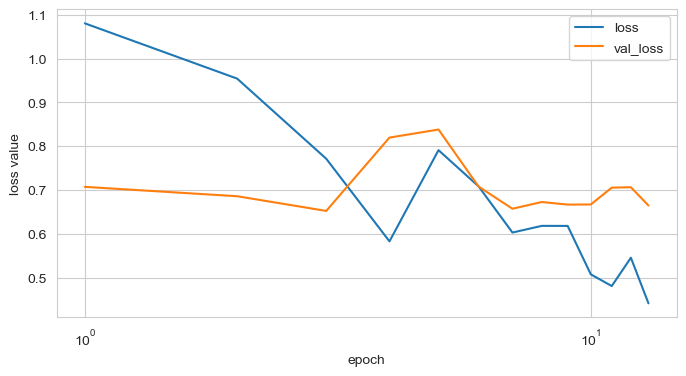

In [52]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,4),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')

plt.xlabel('epoch',fontsize=10)
plt.ylabel('loss value',fontsize=10)
plt.legend(loc=1,fontsize=10);

### 3.4 Model Evaluation

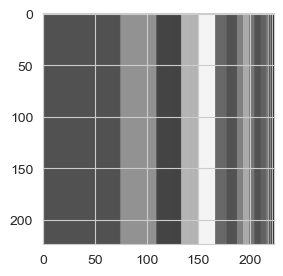

In [53]:
# show and preprocess image
test_image = show_preprocess_image('raw/1/pic1.jpg')

In [54]:
def image_predict(preprocessed_image, model):
    """
    returns class probabilities for a given image,
    based on the model obtained via transfer learning 
    """
    probabilities = model.predict(
        preprocessed_image,
        verbose=0
    )
    probabilities = np.round(probabilities,6)[0]
    class_probabilities = dict(zip(CLASSES,probabilities))
    
    return class_probabilities

In [55]:
# predict image class
image_predict(test_image, h_model)

{'0': 0.32676, '1': 0.67324}

In [56]:
# generate batches of x and y arrays from directory

test_data_gen = data_gen.flow_from_directory(
        directory='raw',
        class_mode="categorical",
        classes=CLASSES,
        target_size=(224, 224)
)

Found 32 images belonging to 2 classes.


In [57]:
# load in all images at once
xtest, ytest = next(test_data_gen)
xtest.shape, ytest.shape

((32, 224, 224, 3), (32, 2))

In [58]:
def transfer_learning_prediction(model, x, y):
    """
    returns dataframe with class probabilities and true class label 
    """
    # prediction dataframe along with true class
    df_pred = pd.DataFrame(
        columns=CLASSES,
        data=np.round(model.predict(x,verbose=0),6)
    )
    # convert vectorized classes into strings
    df_pred['class'] = \
    [''.join([i*j for (i,j) in zip(CLASSES,vector)]) for vector in y.astype(int)]
    
    return df_pred

In [59]:
# model predictions

test_prediction = transfer_learning_prediction(
    h_model,
    xtest,
    ytest
)

test_prediction

,0,1,class
0,0.508793,0.491207,1
1,0.210591,0.789409,1
2,0.610342,0.389658,0
3,0.763487,0.236513,0
4,0.326760,0.673240,1
5,0.830090,0.169910,0
6,0.372068,0.627932,1
7,0.513886,0.486114,0
8,0.494483,0.505517,1
9,0.209943,0.790057,1


In [60]:
def accuracy_score(model,x,y):
    """
    This function spits out multi-class accuracy
    """
    grouped_df = transfer_learning_prediction(
        model, x, y
    ).groupby('class').sum()
    
    grouped_df.sort_index(axis=1,inplace=True)
    
    accuracy_score = np.trace(grouped_df)/np.array(grouped_df).sum()
    accuracy_score = round(accuracy_score,6)
    
    return accuracy_score

In [61]:
accuracy_score(h_model, xtest, ytest)

0.634542

In [62]:
accuracy_score(h_model, xtrain, ytrain)

0.634543

<hr style="border:2px solid black">